In [3]:
excol = [
    'TOTSQFT_EN',
    'TYPEHUQ',
    'urban_grouped',
    'acequipm_pub_grouped',
    'FUELHEAT',
    'EQUIPM',
    'YEARMADERANGE',
    'CELLAR',
    'WALLTYPE',
    'BASEFIN',
    'num_u65',
    'NUMADULT2',
]

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from joblib import load

In [7]:
def data_check(df, column_name):
    """
    Reports the condition of a DataFrame column, including:
    - NaN and Inf counts
    - Value counts (if unique values < 20)
    - Range of values
    - Summary statistics (mean, std, etc.)
    - Histogram (excluding outliers)
    
    Parameters:
    - df: pandas DataFrame
    - column_name: str, name of the column to analyze
    
    Returns:
    - None (prints the report and shows a histogram)
    """
    if column_name not in df.columns:
        print(f"Column '{column_name}' does not exist in the DataFrame.")
        return
    
    col = df[column_name]
    
    # Report NaN and Inf counts
    nan_count = col.isna().sum()
    inf_count = np.isinf(col).sum()
    print(f"NaN values: {nan_count}")
    print(f"Inf values: {inf_count}")
    
    # Value counts (if unique values < 20)
    unique_values = col.nunique()
    if unique_values <= 20:
        print("\nValue counts:")
        print(col.value_counts())
    
    # Range (excluding NaN and Inf)
    finite_col = col[~col.isna() & ~np.isinf(col)]
    if not finite_col.empty:
        min_value = finite_col.min()
        max_value = finite_col.max()
        print(f"\nRange: [{min_value}, {max_value}]")
    else:
        print("\nNo valid data for range computation.")
    
    # Summary statistics
    mean = finite_col.mean()
    std = finite_col.std()
    print(f"Mean: {mean}")
    print(f"Standard deviation: {std}")
    
    # Histogram (excluding outliers using 1.5*IQR rule)
    q1 = finite_col.quantile(0.25)
    q3 = finite_col.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_col = finite_col[(finite_col >= lower_bound) & (finite_col <= upper_bound)]
    
    plt.figure(figsize=(8, 5))
    plt.hist(filtered_col, bins=20, color='blue', alpha=0.7)
    plt.title(f"Histogram of {column_name} (excluding outliers)")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.5)
    plt.show()


In [93]:
buildings = gpd.read_file('E:/Coding/RampIthaca/JBPS/CalibratedBaseline_0215b_PVDHW.geojson')#'data/buildings_joined_everything_ithaca.geojson')

In [65]:
group_numbers = [1, 2, 3, 4, 5]
systems_pipelines = []
construction_pipelines = []
for gn in group_numbers:
    s_pipeline = load(f'models/Systems_{gn}.joblib')
    c_pipeline = load(f'models/Construction_{gn}.joblib')
    systems_pipelines.append(s_pipeline)
    construction_pipelines.append(c_pipeline)
spaceloads_pipeline = load('models/SpaceLoads_all.joblib')

In [13]:
excol

['TOTSQFT_EN',
 'TYPEHUQ',
 'urban_grouped',
 'acequipm_pub_grouped',
 'FUELHEAT',
 'EQUIPM',
 'YEARMADERANGE',
 'CELLAR',
 'WALLTYPE',
 'BASEFIN',
 'num_u65',
 'NUMADULT2']

In [55]:
buildings['area'] / 0.092903 * buildings['usace_num_story'].apply(lambda x: max(x, 1))
buildings['typehuq']
buildings['urban']
buildings['acequipm_pub'] # filter nan values
buildings['fuelheat']
buildings['equipm']
buildings['yearmaderange']
buildings['cellar']
buildings['wall_type']
buildings['basefin']
buildings['num_u65']
buildings['num_o65']

0       5338.169842
1       5099.301313
2       4185.884065
3       5302.352856
4       3603.217176
           ...     
7891     438.218125
7892     438.218518
7893     139.751085
7894     104.825466
7895    2252.413591
Length: 7896, dtype: float64

In [15]:
areas = buildings['area'] / 0.092903 * buildings['usace_num_story'].apply(lambda x: max(x, 1))

NaN values: 0
Inf values: 0

Range: [0.0, 56.0]
Mean: 0.9135287485907554
Standard deviation: 2.0165412200971904


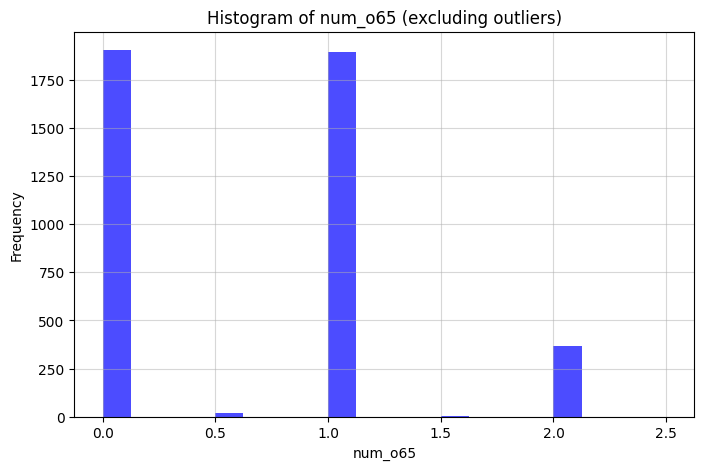

In [17]:
data_check(buildings[buildings['typehuq'] != -1], 'num_o65')

### Actual Prediction Pipelines

In [52]:
formalized_data_all = pd.DataFrame({
    'TOTSQFT_EN': buildings['area'] / 0.092903 * buildings['usace_num_story'].apply(lambda x: max(x, 1)),
    'TYPEHUQ': buildings['typehuq'],
    'urban_grouped': buildings['urban'],
    'acequipm_pub_grouped': buildings['acequipm_pub'].fillna(0), # filter nan values
    'FUELHEAT': buildings['fuelheat'],
    'EQUIPM': buildings['equipm'],
    'YEARMADERANGE': buildings['yearmaderange'],
    'CELLAR': buildings['cellar'],
    'WALLTYPE': buildings['wall_type'],
    'BASEFIN': buildings['basefin'],
    'num_u65': buildings['num_u65'],
    'NUMADULT2': buildings['num_o65'],
})
formalized_data = formalized_data_all[buildings['typehuq'] != -1]

In [54]:
def predict_archetype(x):
    x = x.copy()
    x['construction_subarchetype'] = -1
    x['systems_subarchetype'] = -1
    x['spaceloads_subarchetype'] = -1
    for i in range(5):
        
        cons = construction_pipelines[i].predict(
            x[x['TYPEHUQ'] == (i + 1)]
        )
        sys = systems_pipelines[i].predict(
            x[x['TYPEHUQ'] == (i + 1)]
        )
        x.loc[x['TYPEHUQ'] == (i + 1), 'construction_subarchetype'] = cons
        x.loc[x['TYPEHUQ'] == (i + 1), 'systems_subarchetype'] = sys    
    x['spaceloads_subarchetype'] = spaceloads_pipeline.predict(x)
    return x

In [69]:
predicted_data = predict_archetype(formalized_data)

In [71]:
residential = buildings.loc[formalized_data.index]
residential['construction_subarchetype'] = predicted_data['construction_subarchetype']
residential['systems_subarchetype'] = predicted_data['systems_subarchetype']
residential['spaceloads_subarchetype'] = predicted_data['spaceloads_subarchetype']

In [97]:
buildings.loc[formalized_data.index, 'construction_subarchetype'] = predicted_data['construction_subarchetype']
buildings.loc[formalized_data.index, 'systems_subarchetype'] = predicted_data['systems_subarchetype']
buildings.loc[formalized_data.index, 'spaceloads_subarchetype'] = predicted_data['spaceloads_subarchetype']

In [81]:
#residential.to_file('data/residential_ithaca_archetyped_new.geojson')

<Axes: >

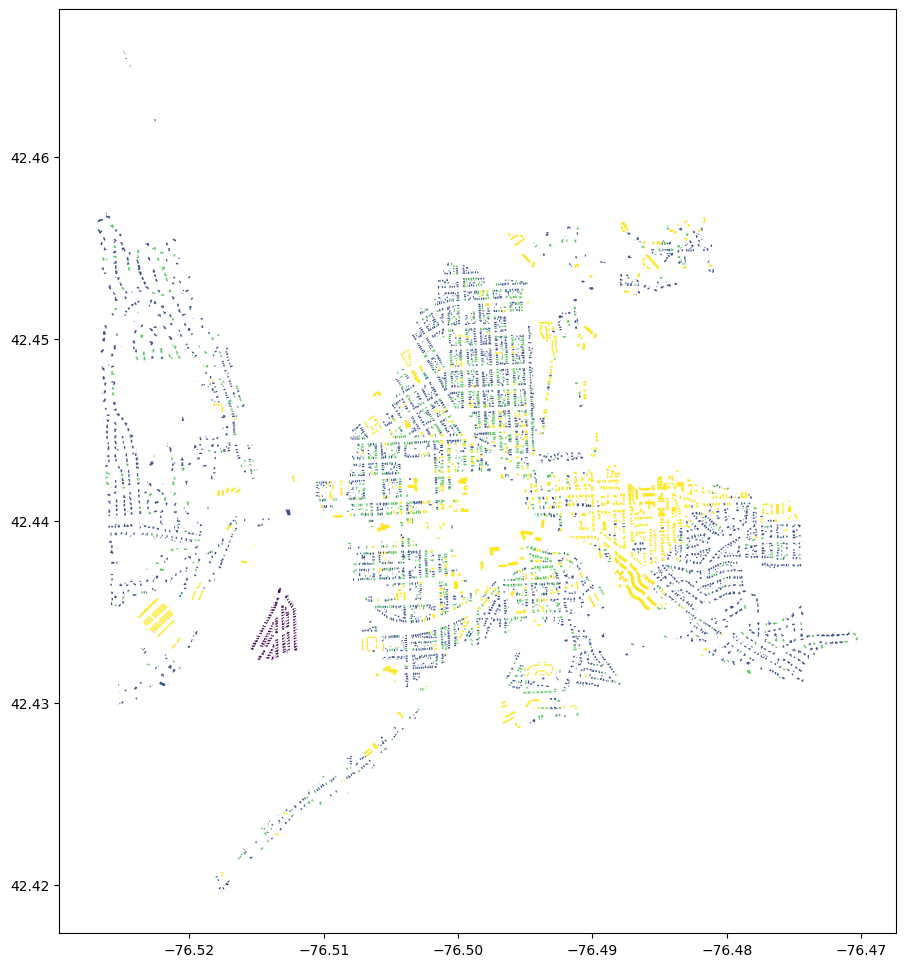

In [220]:
residential.plot('typehuq', figsize=(12, 12),)

<Axes: >

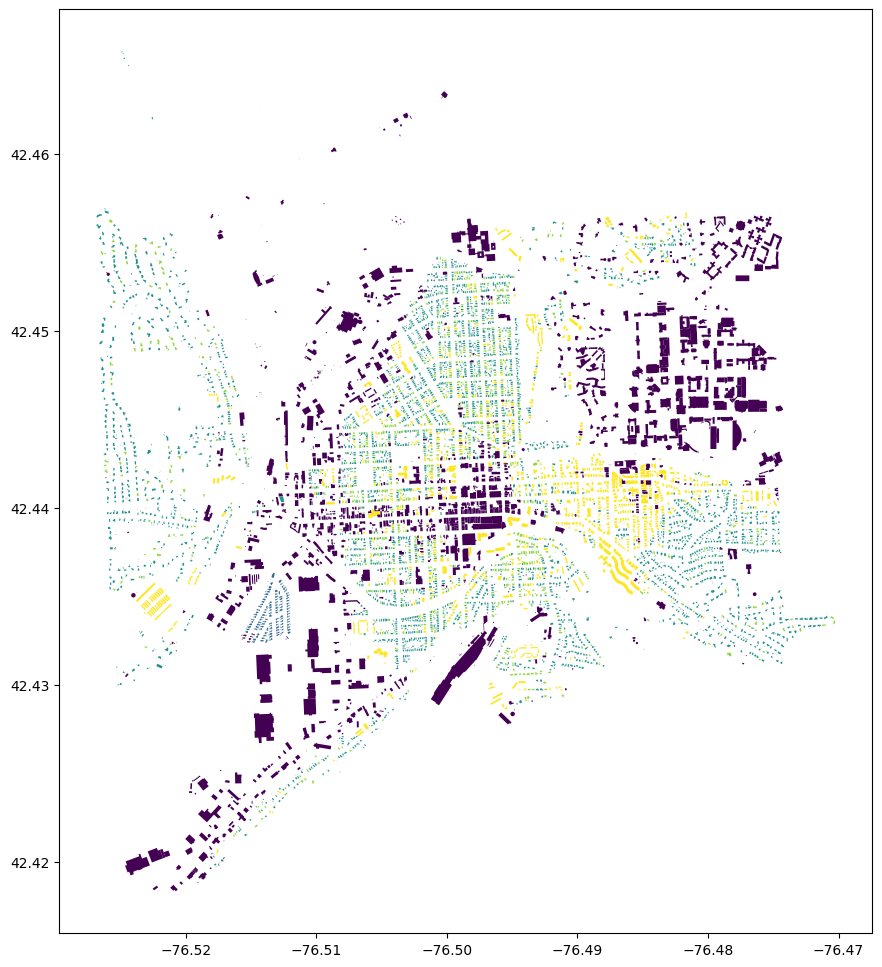

In [222]:
buildings.plot('typehuq', figsize=(12, 12),)

In [299]:
#gpd.GeoDataFrame(buildings[buildings['typehuq'] == -1]).to_file('data/nonresidential_ithaca_archetyped_new.geojson')

In [ ]:
gpd.GeoDataFrame(buildings[buildings['typehuq'] == -1]).to_file('data/nonresidential_ithaca_archetyped_new.geojson')

In [60]:
buildings['spaceloads_subarchetype']

0       2.0
1       2.0
2       2.0
3       2.0
4       2.0
       ... 
5216    NaN
5217    NaN
5218    NaN
5219    NaN
5220    NaN
Name: spaceloads_subarchetype, Length: 5221, dtype: float64

In [33]:
reference = gpd.read_file('E:/Coding/RampIthaca/RCTest/archive/20250225_reRun/Baseline.geojson')#'data/buildings_joined_everything_ithaca.geojson')

Skipping field Heating[KWh][Mth]: unsupported OGR type: 3
Skipping field Cooling[KWh][Mth]: unsupported OGR type: 3
Skipping field Equipment[KWh][Mth]: unsupported OGR type: 3
Skipping field Lighting[KWh][Mth]: unsupported OGR type: 3
Skipping field HotWater[KWh][Mth]: unsupported OGR type: 3
Skipping field GasEquipment[KWh][Mth]: unsupported OGR type: 3
Skipping field Auxiliary[KWh][Mth]: unsupported OGR type: 3
Skipping field Gas[kWh][Mth]: unsupported OGR type: 3
Skipping field Electricity[kWh][Mth]: unsupported OGR type: 3
Skipping field CO2[kg][Mth]: unsupported OGR type: 3
Skipping field CO2_Gas[kg][Mth]: unsupported OGR type: 3
Skipping field CO2_Electricity[kg][Mth]: unsupported OGR type: 3
Skipping field WWR_E_S_W_N_R_ESL: unsupported OGR type: 3


In [79]:
(reference['systems_subarchetype'] - buildings['systems_subarchetype']).apply(abs).sum()

np.float64(0.0)

<Axes: >

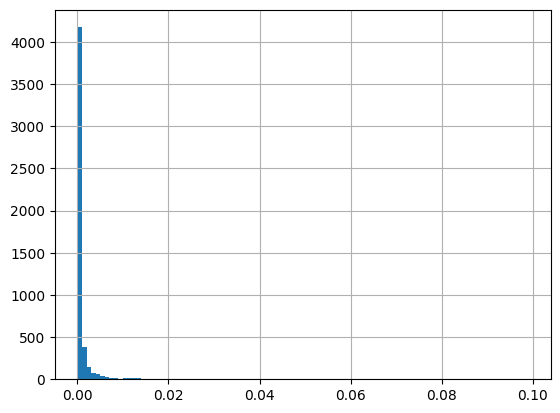

In [95]:
buildings['flowDHW[m3_h_P]_ESL'].hist(bins=np.arange(0, 0.1, 0.001))

In [99]:
#buildings.to_file('0225_new_archetype.geojson')

In [101]:
vres = buildings[buildings['typehuq'] > 0]

In [113]:
vres['HotWater[KWh][Yr]'] / vres['flowDHW[m3_h_P]_ESL'] / (vres['peopleDen[P_m2]_ESL'] * vres['FloorArea[Sqm]'])

0       590599.2
1       590599.2
2       590599.2
3       590599.2
4       590599.2
          ...   
4430    590599.2
4431    590599.2
4432    590599.2
4433    590599.2
4434    590599.2
Length: 4435, dtype: float64

In [111]:
vres['HotWater[KWh][Yr]']

0         59.1
1         59.1
2         70.6
3        138.9
4       2754.0
         ...  
4430    1290.1
4431      59.1
4432      59.1
4433      60.3
4434    1302.8
Name: HotWater[KWh][Yr], Length: 4435, dtype: float64